In [90]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

### Funções

In [91]:
K_BASE = 24.0

def event_importance(level, rnd):
    # Sackmann: G=Slams, M=Masters, F=Tour Finals, A=ATP (500/250), C=Challenger
    if level == 'G': return 1.50
    if level == 'M': return 1.25
    if level == 'F':  # Tour Finals
        return 1.60 if rnd in {'SF', 'F'} else 1.25
    if level == 'A': return 1.10   # treat ATP main-draw (250/500) similarly
    if level == 'C': return 1.00
    return 1.00

def sets_factor(best_of):
    try:
        return 1.35 if int(best_of) >= 5 else 1.00
    except Exception:
        return 1.00

def add_pre_match_elo(df_original):
    """
    Adiciona colunas de Elo pré-jogo geral e por superfície.
    Colunas novas:
      - pre_surface_elo_1, pre_surface_elo_2
      - post_surface_elo_1, post_surface_elo_2
      - (opcional) exp_surface_1, exp_surface_2
    """
    df = df_original.copy()
    df = df.sort_values(["tourney_date", "match_num"], kind="mergesort").reset_index(drop=True)

    # Elo geral
    ratings = {}  # player_id -> Elo
    # Elo por superfície
    ratings_surface = {}  # (surface, player_id) -> Elo

    pre_1, pre_2, exp_1, exp_2, post_1, post_2 = [], [], [], [], [], []
    pre_s1, pre_s2, exp_s1, exp_s2, post_s1, post_s2 = [], [], [], [], [], []

    for r in df.itertuples(index=False):
        p1 = r.player1_id
        p2 = r.player2_id
        surf = getattr(r, "surface", None)

        # Elo geral atual
        R1 = ratings.get(p1, 1500.0)
        R2 = ratings.get(p2, 1500.0)

        # Elo por superfície atual (fallback para Elo geral se surface ausente)
        if surf is None or pd.isna(surf):
            RS1, RS2 = R1, R2
        else:
            RS1 = ratings_surface.get((surf, p1), 1500.0)
            RS2 = ratings_surface.get((surf, p2), 1500.0)

        # guarda pré-jogo
        pre_1.append(R1)
        pre_2.append(R2)
        pre_s1.append(RS1)
        pre_s2.append(RS2)

        # expectativas
        Ew = 1.0 / (1.0 + 10 ** ((R2 - R1) / 400.0))
        El = 1.0 - Ew
        exp_1.append(Ew)
        exp_2.append(El)

        # expectativa superfície
        Es1 = 1.0 / (1.0 + 10 ** ((RS2 - RS1) / 400.0))
        Es2 = 1.0 - Es1
        exp_s1.append(Es1)
        exp_s2.append(Es2)

        # K por partida
        K = K_BASE * event_importance(getattr(r, "tourney_level", "A"), getattr(r, "round", ""))
        K *= sets_factor(getattr(r, "best_of", 3))

        # atualiza Elo geral
        R1_new = R1 + K * (1.0 - Ew)
        R2_new = R2 + K * (0.0 - El)
        ratings[p1] = R1_new
        ratings[p2] = R2_new
        post_1.append(R1_new)
        post_2.append(R2_new)

        # atualiza Elo por superfície (se conhecida; senão, espelha o geral)
        if surf is None or pd.isna(surf):
            RS1_new, RS2_new = R1_new, R2_new
        else:
            RS1_new = RS1 + K * (1.0 - Es1)
            RS2_new = RS2 + K * (0.0 - Es2)
            ratings_surface[(surf, p1)] = RS1_new
            ratings_surface[(surf, p2)] = RS2_new
        post_s1.append(RS1_new)
        post_s2.append(RS2_new)

    # escreve colunas
    df["pre_elo_1"] = pre_1
    df["pre_elo_2"] = pre_2
    df["exp_1"] = exp_1
    df["exp_2"] = exp_2
    df["post_elo_1"] = post_1
    df["post_elo_2"] = post_2

    df["pre_surface_elo_1"] = pre_s1
    df["pre_surface_elo_2"] = pre_s2
    df["exp_surface_1"] = exp_s1
    df["exp_surface_2"] = exp_s2
    df["post_surface_elo_1"] = post_s1
    df["post_surface_elo_2"] = post_s2
    return df

def rolling_slope(seq, min_points=2):
    """
    Retorna o coeficiente angular (slope) de y ~ x para a sequência 'seq'.
    Aceita deque/list/ndarray com menos que o maxlen. 
    Se n < min_points → NaN. Se var(x)=0 → 0.0.
    """
    n = len(seq)
    if n < min_points:
        return np.nan

    x = np.arange(n, dtype=float)
    y = np.asarray(seq, dtype=float)

    # slope = cov(x,y) / var(x)  (mais leve que polyfit)
    xm = x.mean()
    ym = y.mean()
    denom = np.sum((x - xm) ** 2)
    if denom == 0.0:
        return 0.0
    return np.sum((x - xm) * (y - ym)) / denom

def safe_mean(seq):
    return np.mean(seq) if len(seq) > 0 else np.nan

def balance_matches(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    rng = np.random.default_rng(42)

    # Máscara para trocar metade das linhas
    swap_mask = np.zeros(len(df), dtype=bool)
    idx = np.arange(len(df))
    rng.shuffle(idx)
    swap_mask[idx[:len(df)//2]] = True

    # Detecta colunas de diferença
    diff_cols = [
        c for c in df.columns
        if c.lower().endswith('_diff') or 'differential' in c.lower()
    ]
    # Garante que são numéricas
    diff_cols = [c for c in diff_cols if np.issubdtype(df[c].dtype, np.number)]

    # Troca jogadores
    df.loc[swap_mask, ['player1_id', 'player2_id']] = (
        df.loc[swap_mask, ['player2_id', 'player1_id']].values
    )

    # Inverte sinal das diferenças
    df.loc[swap_mask, diff_cols] = -df.loc[swap_mask, diff_cols].values

    # Cria alvo (player1 vence = 1, player2 vence = 0)
    df['winner'] = np.where(swap_mask, 0, 1)

    return df

def get_players_surface_elo_series(player_id, df, surface):
    pm = df[(df['player1_id'] == player_id) | (df['player2_id'] == player_id)].copy()
    pm = pm[pm['surface'] == surface] if surface is not 'All' else pm

    rows = []
    for r in pm.itertuples(index=False):
        if surface == 'All':
            elo = r.pre_elo_1 if r.player1_id == player_id else r.pre_elo_2
        else:
            elo = r.pre_surface_elo_1 if r.player1_id == player_id else r.pre_surface_elo_2
        rows.append([r.tourney_date, elo])
    return pd.DataFrame(rows, columns=['date','elo']).set_index('date').sort_index()



<>:168: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
C:\Users\Pedro Mesquita\AppData\Local\Temp\ipykernel_20792\15913177.py:168: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
  pm = pm[pm['surface'] == surface] if surface is not 'All' else pm


### Tratamento

In [92]:
matches_list = []
for year in range(1968, 2025):
    matches = pd.read_csv(f'./data/atp_matches_{year}.csv')
    matches_list.append(matches)
all_matches = pd.concat(matches_list, ignore_index=True)

In [93]:
all_matches['tourney_date'] = pd.to_datetime(all_matches['tourney_date'], format='%Y%m%d')

In [94]:
columns = [
    'winner_id', 'loser_id', 'winner_rank', 'loser_rank',
    'winner_age', 'loser_age', 'winner_ht', 'loser_ht',
    'w_ace', 'w_df', 'w_svpt','w_1stIn', 'w_1stWon', 'w_2ndWon','w_SvGms', 'w_bpSaved', 'w_bpFaced',
    'l_ace', 'l_df', 'l_svpt','l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
    'surface', 'loser_rank_points', 'winner_rank_points'
]
all_matches = all_matches.dropna(subset=columns)

In [95]:
all_matches.columns = [i.replace('l_', 'player2_').replace('loser_','player2_').replace('w_', 'player1_').replace('winner_','player1_') if i.startswith('w') or i.startswith('l') else i for i in all_matches.columns]
columns = all_matches.columns.to_list()
columns += ['pre_elo_1', 'pre_elo_2', 'pre_surface_elo_1', 'pre_surface_elo_2']

In [96]:
eloed_matches = add_pre_match_elo(all_matches)

In [97]:
eloed_matches = eloed_matches[columns]

In [98]:
from collections import defaultdict, deque

from tqdm import tqdm


h2h_surface_dict = defaultdict(lambda: defaultdict(int))
h2h_dict = defaultdict(int)
total_h2h_surface = []
total_h2h = []

for idx, (w_id,l_id,surface) in enumerate(tqdm(zip(
        eloed_matches['player1_id'],
        eloed_matches['player2_id'],
        eloed_matches['surface']), 
        total=len(eloed_matches))):
    
    wins = h2h_dict[(w_id, l_id)]
    losses = h2h_dict[(l_id, w_id)]

    wins_surface = h2h_surface_dict[surface][(w_id, l_id)]
    losses_surface = h2h_surface_dict[surface][(l_id, w_id)]

    total_h2h.append(wins - losses)
    total_h2h_surface.append(wins_surface - losses_surface)

    h2h_dict[(w_id, l_id)] += 1
    h2h_surface_dict[surface][(w_id, l_id)] += 1


100%|██████████| 95375/95375 [00:00<00:00, 377038.08it/s]


In [99]:
df_final = eloed_matches[['player1_id', 'player2_id', 'best_of', 'draw_size']].copy()
df_final['atp_points_differential'] = eloed_matches['player1_rank_points'] - eloed_matches['player2_rank_points']
df_final['atp_rank_differential'] = eloed_matches['player1_rank'] - eloed_matches['player2_rank']
df_final['age_differential'] = eloed_matches['player1_age'] - eloed_matches['player2_age']
df_final['ht_differential'] = eloed_matches['player1_ht'] - eloed_matches['player2_ht']
df_final['elo_differential'] = eloed_matches['pre_elo_1'] - eloed_matches['pre_elo_2']
df_final['elo_surface_differential'] = (
    eloed_matches['pre_surface_elo_1'] - eloed_matches['pre_surface_elo_2']
)
df_final['h2h_differential'] = total_h2h
df_final['h2h_surface_differential'] = total_h2h_surface

In [100]:
df_final

,player1_id,player2_id,best_of,draw_size,atp_points_differential,atp_rank_differential,age_differential,ht_differential,elo_differential,elo_surface_differential,h2h_differential,h2h_surface_differential
0,101142,101746,3,32.0,1028.0,-69.0,5.0,5.0,0.000000,0.000000,0,0
1,100923,100656,3,32.0,-2026.0,52.0,-3.2,-8.0,0.000000,0.000000,0,0
2,101613,100587,3,32.0,257.0,-126.0,-10.3,-8.0,0.000000,0.000000,0,0
3,101196,101511,3,32.0,-295.0,24.0,2.9,10.0,0.000000,0.000000,0,0
4,101179,101601,3,32.0,352.0,-135.0,3.7,0.0,0.000000,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
95370,210530,209950,5,8.0,-1862.0,102.0,-1.5,-5.0,-232.034982,-162.285507,-1,-1
95371,209950,210150,5,8.0,1219.0,-28.0,1.3,-8.0,46.529254,-15.177155,0,0
95372,210530,210506,5,8.0,-752.0,81.0,-1.3,-13.0,-157.014800,-152.809756,0,0
95373,211663,209414,5,8.0,-62.0,17.0,-2.2,7.0,80.052474,50.048493,0,0


In [101]:
for k in [3, 5, 10, 20]:
    elo_hist = defaultdict(lambda: deque(maxlen=k))
    elo_grad_k = []
    elo_surface_hist = defaultdict(lambda: deque(maxlen=k))
    elo_surface_grad_k = []

    k_last_matches = defaultdict(lambda: defaultdict(lambda: deque(maxlen=k)))
    p_ace_k = []
    p_df_k = []
    p_1stIn_k = []
    p_1stWon_k = []
    p_2ndWon_k = []
    p_bpSaved_k = []
    wins_hist = defaultdict(lambda: deque(maxlen=k))
    wins_lastk_diff = []


    print(k, end=': ')
    for row in tqdm(eloed_matches.itertuples(index=False), total=len(eloed_matches)):
        player1_id, player2_id = row.player1_id, row.player2_id
        player1_ace, player2_ace = row.player1_ace, row.player2_ace
        player1_df, player2_df = row.player1_df, row.player2_df
        player1_svpt, player2_svpt = row.player1_svpt, row.player2_svpt
        player1_1stIn, player2_1stIn = row.player1_1stIn, row.player2_1stIn
        player1_1stWon, player2_1stWon = row.player1_1stWon, row.player2_1stWon
        player1_2ndWon, player2_2ndWon = row.player1_2ndWon, row.player2_2ndWon
        player1_SvGms, player2_SvGms = row.player1_SvGms, row.player2_SvGms
        player1_bpSaved, player2_bpSaved = row.player1_bpSaved, row.player2_bpSaved
        player1_bpFaced, player2_bpFaced = row.player1_bpFaced, row.player2_bpFaced
        player1_elo, player2_elo = row.pre_elo_1, row.pre_elo_2
        player1_elo_surface, player2_elo_surface = row.pre_surface_elo_1, row.pre_surface_elo_2

        p_ace_k.append(safe_mean(k_last_matches[player1_id]["p_ace"]) - safe_mean(k_last_matches[player2_id]["p_ace"]))
        p_df_k.append(safe_mean(k_last_matches[player1_id]["p_df"]) - safe_mean(k_last_matches[player2_id]["p_df"]))
        p_1stIn_k.append(safe_mean(k_last_matches[player1_id]["p_1stIn"]) - safe_mean(k_last_matches[player2_id]["p_1stIn"]))
        p_1stWon_k.append(safe_mean(k_last_matches[player1_id]["p_1stWon"]) - safe_mean(k_last_matches[player2_id]["p_1stWon"]))
        p_2ndWon_k.append(safe_mean(k_last_matches[player1_id]["p_2ndWon"]) - safe_mean(k_last_matches[player2_id]["p_2ndWon"]))
        p_bpSaved_k.append(safe_mean(k_last_matches[player1_id]["p_bpSaved"]) - safe_mean(k_last_matches[player2_id]["p_bpSaved"]))

        grad_w = rolling_slope(elo_hist[player1_id])
        grad_l = rolling_slope(elo_hist[player2_id])
        grad_w_surface = rolling_slope(elo_hist[player1_id])
        grad_l_surface = rolling_slope(elo_hist[player2_id])
        elo_grad_k.append(grad_w - grad_l)
        elo_surface_grad_k.append(grad_w_surface - grad_l_surface)

        wins_lastk_diff.append(sum(wins_hist[player1_id]) - sum(wins_hist[player2_id]))

        # --------- UPDATE HISTORYS (after computing features!) ---------
        # update Elo history with current *pre-match* Elo
        elo_hist[player1_id].append(player1_elo)
        elo_hist[player2_id].append(player2_elo)
        elo_surface_hist[player1_id].append(player1_elo_surface)
        elo_surface_hist[player2_id].append(player2_elo_surface)


        # Update
        if (player1_svpt != 0) and (player1_svpt != player1_1stIn):
            # Percentage of aces
            k_last_matches[player1_id]["p_ace"].append(100 * (player1_ace / player1_svpt))

            # Percentage of double faults
            k_last_matches[player1_id]["p_df"].append(100 * (player1_df / player1_svpt))

            # Percentage of first serve in
            k_last_matches[player1_id]["p_1stIn"].append(100 * (player1_1stIn / player1_svpt))

            k_last_matches[player1_id]["p_2ndWon"].append(100 * (player1_2ndWon / (player1_svpt - player1_1stIn)))

        # Update loser stats
        if (player2_svpt != 0) and (player2_svpt != player2_1stIn):
            k_last_matches[player2_id]["p_ace"].append(100 * (player2_ace / player2_svpt))
            k_last_matches[player2_id]["p_df"].append(100 * (player2_df / player2_svpt))
            k_last_matches[player2_id]["p_1stIn"].append(100 * (player2_1stIn / player2_svpt))
            k_last_matches[player2_id]["p_2ndWon"].append(100 * (player2_2ndWon / (player2_svpt - player2_1stIn)))

        # Percentage of first serve won
        if player1_1stIn != 0:
            k_last_matches[player1_id]["p_1stWon"].append(100 * (player1_1stWon / player1_1stIn))
        if player2_1stIn != 0:
            k_last_matches[player2_id]["p_1stWon"].append(100 * (player2_1stWon / player2_1stIn))

        # Percentage of break points saved
        if player1_bpFaced != 0:
            k_last_matches[player1_id]["p_bpSaved"].append(100 * (player1_bpSaved / player1_bpFaced))
        if player2_bpFaced != 0:
            k_last_matches[player2_id]["p_bpSaved"].append(100 * (player2_bpSaved / player2_bpFaced))

        wins_hist[player1_id].append(1)
        wins_hist[player2_id].append(0)


    # Final data aggregation
    df_final["p_ace_last" + str(k) + "_differential"] = p_ace_k
    df_final["p_df_last" + str(k) + "_differential"] = p_df_k
    df_final["p_1st_in_last" + str(k) + "_differential"] = p_1stIn_k
    df_final["p_1st_won_last" + str(k) + "_differential"] = p_1stWon_k
    df_final["p_2nd_won_last" + str(k) + "_differential"] = p_2ndWon_k
    df_final["p_bp_saved_last" + str(k) + "_differential"] = p_bpSaved_k
    df_final[f"elo_gradient_{k}_differential"] = elo_grad_k
    df_final[f"elo_surface_gradient_{k}_differential"] = elo_surface_grad_k
    df_final[f"wins_last{k}_differential"] = wins_lastk_diff



3: 

100%|██████████| 95375/95375 [00:15<00:00, 6153.33it/s]


5: 

100%|██████████| 95375/95375 [00:15<00:00, 6069.08it/s]


10: 

100%|██████████| 95375/95375 [00:15<00:00, 6233.70it/s]


20: 

100%|██████████| 95375/95375 [00:16<00:00, 5862.16it/s]


In [102]:
df_final.sample()

,player1_id,player2_id,best_of,draw_size,atp_points_differential,atp_rank_differential,age_differential,ht_differential,elo_differential,elo_surface_differential,h2h_differential,h2h_surface_differential,p_ace_last3_differential,p_df_last3_differential,p_1st_in_last3_differential,p_1st_won_last3_differential,p_2nd_won_last3_differential,p_bp_saved_last3_differential,elo_gradient_3_differential,elo_surface_gradient_3_differential,wins_last3_differential,p_ace_last5_differential,p_df_last5_differential,p_1st_in_last5_differential,p_1st_won_last5_differential,p_2nd_won_last5_differential,p_bp_saved_last5_differential,elo_gradient_5_differential,elo_surface_gradient_5_differential,wins_last5_differential,p_ace_last10_differential,p_df_last10_differential,p_1st_in_last10_differential,p_1st_won_last10_differential,p_2nd_won_last10_differential,p_bp_saved_last10_differential,elo_gradient_10_differential,elo_surface_gradient_10_differential,wins_last10_differential,p_ace_last20_differential,p_df_last20_differential,p_1st_in_last20_differential,p_1st_won_last20_differential,p_2nd_won_last20_differential,p_bp_saved_last20_differential,elo_gradient_20_differential,elo_surface_gradient_20_differential,wins_last20_differential
86093,105453,111815,3,64.0,-972.0,38.0,5.6,-10.0,-48.164038,82.24728,1,0,-5.726196,0.753888,-1.901919,-7.592457,9.640802,25.396825,-9.686763,-9.686763,0,-3.59148,-1.488177,0.568499,-7.494723,6.399455,31.601732,-11.364183,-11.364183,-1,-4.242255,-1.477443,-0.149515,-9.090964,2.844571,4.213522,-4.359324,-4.359324,-1,-3.958388,-2.034538,-1.013102,-9.525272,1.577605,-5.960838,-2.853566,-2.853566,-3


In [ ]:
balanced_df = balance_matches(df_final)

In [104]:
balanced_df.to_csv('./data/atp_matches_features_balanced.csv', index=False)

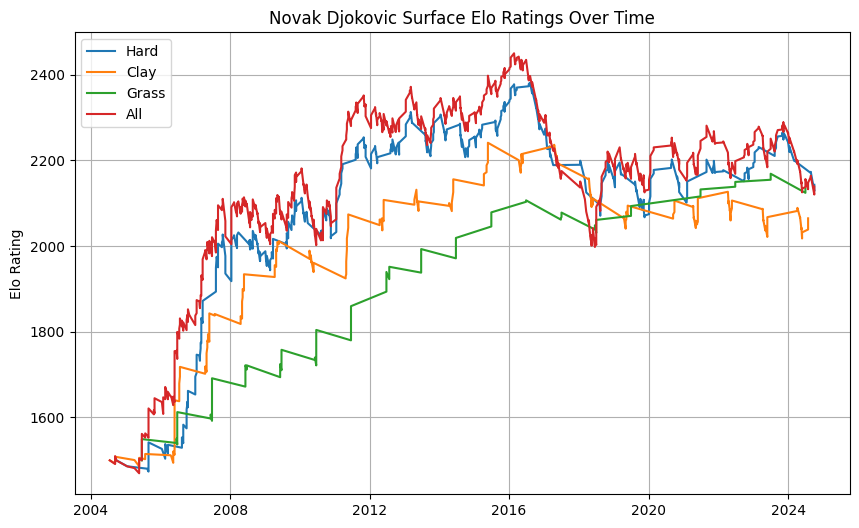

In [105]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10, 6))
for surface in ['Hard', 'Clay', 'Grass', 'All']:
    plot_df = get_players_surface_elo_series(104925, eloed_matches, surface)
    plt.plot(plot_df.index, plot_df['elo'], label=surface)

plt.legend()
plt.title('Novak Djokovic Surface Elo Ratings Over Time')
plt.ylabel('Elo Rating')
plt.grid(True)

In [1]:
import seaborn as sns

sns.pairplot(balanced_df.sample(1000))  # sample for speed if dataset is large

NameError: name 'balanced_df' is not defined